# Re-usable data ipynb

In [3]:
# https://matplotlib.org/stable/gallery/statistics/time_series_histogram.html#sphx-glr-gallery-statistics-time-series-histogram-py
from copy import copy

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [4]:
# Make some data; a 1D random walk + small fraction of sine waves
num_series = 1000
num_points = 100
SNR = 0.10  # Signal to Noise Ratio
x = np.linspace(0, 4 * np.pi, num_points)
# Generate unbiased Gaussian random walks
Y = np.cumsum(np.random.randn(num_series, num_points), axis=-1)
# Generate sinusoidal signals
num_signal = int(round(SNR * num_series))
phi = (np.pi / 8) * np.random.randn(num_signal, 1)  # small random offset
Y[-num_signal:] = (
    np.sqrt(np.arange(num_points))[None, :]  # random walk RMS scaling factor
    * (np.sin(x[None, :] - phi)
       + 0.05 * np.random.randn(num_signal, num_points))  # small random noise
)


# Now we will convert the multiple time series into a histogram. Not only will
# the hidden signal be more visible, but it is also a much quicker procedure.
# Linearly interpolate between the points in each time series
num_fine = 800
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.empty((num_series, num_fine), dtype=float)
for i in range(num_series):
    y_fine[i, :] = np.interp(x_fine, x, Y[i, :])
y_fine = y_fine.flatten()
x_fine = np.matlib.repmat(x_fine, num_series, 1).flatten()

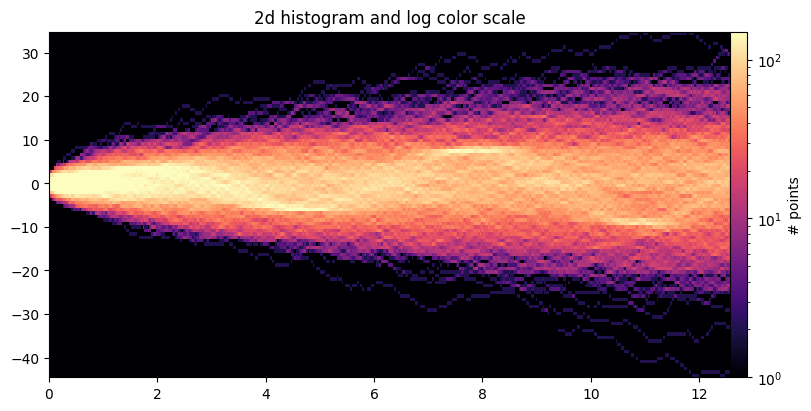

In [6]:
#| label: img:ramdom_walk_hist2d
# 2D 히스토그램과 로그 색상 스케일
fig, axes = plt.subplots(figsize=(8, 4), constrained_layout=True)
cmap = copy(plt.cm.magma)
cmap.set_bad(cmap(0))
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes.pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmax=1.5e2), rasterized=True)
fig.colorbar(pcm, ax=axes, label="# points", pad=0)
axes.set_title("2d histogram and log color scale");

# Table data

In [7]:
# | label: tbl:airport_data
from vega_datasets import data
airports = data.airports()
airports.head()

,iata,name,city,state,country,latitude,longitude
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


## Interactive data

In [8]:
import altair as alt
from vega_datasets import data

source = data.cars()
brush = alt.selection_interval(encodings=['x'])
points = alt.Chart(source).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    size='Acceleration',
    color=alt.condition(brush, 'Origin:N', alt.value('lightgray'))
).add_params(brush)

bars = alt.Chart(source).mark_bar().encode(
    y='Origin:N',
    color='Origin:N',
    x='count(Origin):Q'
).transform_filter(brush)

In [ ]:
# | label : img:Altair
bars&points

alt.VConcatChart(...)

In [ ]:
# | label: img:plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd

# read in volcano database data
df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/volcano_db.csv",
    encoding="iso-8859-1",
)

# frequency of Country
freq = df['Country'].value_counts().reset_index()
freq.columns = ['x', 'Country']

# read in 3d volcano surface data
df_v = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/volcano.csv")

# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[[{"type": "scattergeo", "rowspan": 2}, {"type": "bar"}],
           [            None                    , {"type": "surface"}]])

# Add scattergeo globe map of volcano locations
fig.add_trace(
    go.Scattergeo(lat=df["Latitude"],
                  lon=df["Longitude"],
                  mode="markers",
                  hoverinfo="text",
                  showlegend=False,
                  marker=dict(color="crimson", size=4, opacity=0.8)),
    row=1, col=1
)

# Add locations bar chart
fig.add_trace(
    go.Bar(x=freq["x"][0:10],y=freq["Country"][0:10], marker=dict(color="crimson"), showlegend=False),
    row=1, col=2
)

# Add 3d surface of volcano
fig.add_trace(
    go.Surface(z=df_v.values.tolist(), showscale=False),
    row=2, col=2
)

# Update geo subplot properties
fig.update_geos(
    projection_type="orthographic",
    landcolor="white",
    oceancolor="MidnightBlue",
    showocean=True,
    lakecolor="LightBlue"
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Set theme, margin, and annotation in layout
fig.update_layout(
    template="plotly_dark",
    margin=dict(r=10, t=25, b=40, l=60),
    annotations=[
        dict(
            text="Source: NOAA",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0)
    ]
)

fig.show()